# interpret cell state

In [1]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
import torch
mpl.rcParams['figure.dpi'] = 150

In [2]:
from torch.utils.data import DataLoader
from ruamel.yaml import YAML

In [3]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [4]:
%load_ext autoreload
%autoreload 2

# Load in all of the raw data (original)

In [5]:
# all_data
dynamic = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")

# static_ds = xr.open_dataset(Path(f'data/features/static/data.nc'))
all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

dynamic['station_id'] = dynamic['station_id'].astype(int)

# Code

In [6]:
print([d.name for d in (data_dir / "runs/").iterdir()])
print([d.name for d in (data_dir / "runs/ealstm_less_vars_2004_1607_1334").glob("*")])

(data_dir / "runs/ealstm_less_vars_2004_1607_1334")
(data_dir / "runs/lstm_less_vars_2004_1507_1028")

['ealstm_less_vars_2004_1707_1424', 'lstm_less_vars_2004_1507_1028', 'train_data.h5', 'train_data_scaler.p', 'lstm_ALL_vars_2004_2210_1035', 'lstm_all_vars_1998_2008_2210_110347', 'lstm_all_vars_1998_2008_2210_110727', 'lstm_all_vars_1998_2008_nh_2310_101443', 'lstm_all_vars_1998_2008_nh_2310_142625', 'ensemble__', 'ensemble_EALSTM', 'ensemble_lstm10', 'ensemble', '0_ensemble_results']
[]


PosixPath('/cats/datastore/data/runs/lstm_less_vars_2004_1507_1028')

In [7]:
import sys
sys.path.insert(1, '/home/tommy/neuralhydrology')

from neuralhydrology.modelzoo.ealstm import EALSTM
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.datasetzoo.camelsgb import CamelsGB
from neuralhydrology.datautils.utils import load_basin_file
from neuralhydrology.utils.config import Config
from neuralhydrology.utils.errors import NoTrainDataError
from neuralhydrology.training.train import BaseTrainer

## Load in config file

In [8]:
run_dir = data_dir / "runs/ensemble_EALSTM/ealstm_ensemble6_nse_1998_2008_2910_030601"

# Config file
config_path = (run_dir / "config.yml") 
config = Config(config_path)

## Extra Processes

In [9]:
# Get the list of basins that we actually have results for
lstm_preds_df = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_preds_df["time"] = pd.to_datetime(lstm_preds_df["time"])
lstm_preds = lstm_preds_df.set_index(["station_id", "time"]).to_xarray()

VALID_BASINS = (lstm_preds_df["station_id"].unique())

In [10]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Create Model Embeddings

In [11]:
(run_dir / "model_epoch030.pt")

PosixPath('/cats/datastore/data/runs/ensemble_EALSTM/ealstm_ensemble6_nse_1998_2008_2910_030601/model_epoch030.pt')

In [12]:
# torch.load(model_path, map_location="cpu")

In [13]:
# Initialize model
# EA LSTM
model = EALSTM(config)
model_path = run_dir / "model_epoch030.pt"
model.load_state_dict(torch.load(model_path, map_location="cpu"))

# LSTM
lstm_run_dir = data_dir / "runs/ensemble/lstm_ensemble6_nse_1998_2008_2710_171032"
cfg_lstm = Config(lstm_run_dir / "config.yml")
lstm_model = CudaLSTM(cfg_lstm)
# lstm_model.lstm = LSTM(25, 64)
lstm_model_path = lstm_run_dir / "model_epoch030.pt"
lstm_model.load_state_dict(torch.load(lstm_model_path, map_location="cpu"))

<All keys matched successfully>

# Get cell state over time

In [14]:
# scaler_file = config.train_dir / "train_data_scaler.p"
# scaler = pickle.load(scaler_file.open("rb"))

# try: 
#     globals()["data"]
# except KeyError:
#     # load data
#     data = CamelsGB(config, is_train=False, period="test", scaler=scaler)
    
# DataLoader(data, batch_size=config.batch_size, num_workers=0)

In [15]:
from neuralhydrology.modelzoo.basemodel import BaseModel
from neuralhydrology.evaluation import RegressionTester
from neuralhydrology.utils.errors import NoTrainDataError
from typing import Tuple
from collections import defaultdict


def get_states_from_forward(model: BaseModel, loader: DataLoader, hidden_state: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    all_hidden_states = []
    all_cell_states = []
    # For all the basin data in Loader
    for basin_data in loader:
        with torch.no_grad():
            predict = model.forward(basin_data)
            if hidden_state:
                all_hidden_states.append(predict["h_n"].detach().numpy())
            all_cell_states.append(predict["c_n"].detach().numpy())
    
    basin_cell_states = np.vstack(all_cell_states)
    if hidden_state:
        basin_hidden_states = np.vstack(all_hidden_states)
        return basin_hidden_states, basin_cell_states
    
    else:
        return basin_cell_states

In [16]:
MODEL_STATE_FILE = data_dir / "RUNOFF/MODEL_STATE.pkl"
MODEL_STATE_FILE.exists()

True

In [17]:
catchment_ids = [int(c) for c in ["12002", "15006", "27009", "27034", "27041", "39001", "39081", "43021", "47001", "54001", "54057", "71001", "84013",]]
catchment_names = ["Dee@Park", "Tay@Ballathie", "Ouse@Skelton", "Ure@Kilgram", "Derwent@Buttercrambe", "Thames@Kingston", "Ock@Abingdon", "Avon@Knapp", "Tamar@Gunnislake", "Severn@Bewdley", "Severn@Haw", "Ribble@Samlesbury", "Clyde@Daldowie"]
station_map = dict(zip(catchment_ids, catchment_names))

In [18]:
# TEST_BASINS = [str(id_) for id_ in catchment_ids]
# Tester = RegressionTester(cfg=config, run_dir=run_dir, period="test", init_model=True)
# all_basins = load_basin_file(Path(config.train_basin_file))

# # 1. Run forward passes
# all_basin_data = defaultdict(dict)
# MODEL_STATE_FILE = data_dir / "RUNOFF/MODEL_STATE.pkl"

# if not MODEL_STATE_FILE.exists():
#     # run the forward passes for each basin

#     # For each basin create a DataLoader
#     for ix, basin in enumerate(tqdm(TEST_BASINS)):
#         basin_data = {}
#         basin_file = data_dir / f"RUNOFF/STATE/{basin}.pkl"
#         try:
#             ds = Tester._get_dataset(basin)
#         except NoTrainDataError:
#             print(f"{basin} Missing")
#             continue

#         loader = DataLoader(ds, batch_size=config.batch_size, num_workers=0)
#         _, basin_cell_states = get_states_from_forward(model, loader)
#     #     basin_data["c_s"] = basin_cell_states
#     #     pickle.dump(basin_data, basin_file.open("wb"))
#     #     del basin_data
#         # NOTE: too big to read all into memory
#         # all_basin_data[basin]["h_s"] = basin_hidden_states
#         all_basin_data[basin]["c_s"] = basin_cell_states
#         del basin_cell_states
        
#     pickle.dump(all_basin_data, MODEL_STATE_FILE.open("wb"))
# else:
#     # LOAD MODEL HIDDEN AND CELL STATES
#     try:
#         all_basin_data = pickle.load(MODEL_STATE_FILE.open("rb"))
#     except EOFError:
#         print(f"Empty file: {MODEL_STATE_FILE}")
#         print("try: `MODEL_STATE_FILE.unlink()` (will delete the file and start again)")
        
# # pickle.dump(all_basin_data, MODEL_STATE_FILE.open("wb"))
# all_basin_data
# print("****** DONE DONE DONE *******")

In [19]:
# type(all_basin_data)
# all_basin_data.keys()

In [20]:
from typing import List, Tuple, Dict, DefaultDict

def run_all_basin_forward_passes(
    test_basins: List[str],
    config: Config,
    run_dir: Path,
) -> DefaultDict[str, Dict[str, np.ndarray]]:
    print("-- Run forward pass to extract c_s --")
    # 1. run the forward passes for each basin
    Tester = RegressionTester(cfg=config, run_dir=run_dir, period="test", init_model=True)
    all_basin_data = defaultdict(dict)

    for ix, basin in enumerate(tqdm(test_basins)):
        try:
            # For each basin create a DataLoader
            ds = Tester._get_dataset(basin)
        except NoTrainDataError:
            print(f"{basin} Missing")
            continue

        loader = DataLoader(ds, batch_size=config.batch_size, num_workers=0)
        _, basin_cell_states = get_states_from_forward(model, loader)

        all_basin_data[basin]["c_s"] = basin_cell_states
        del basin_cell_states
    
    return all_basin_data


def create_time_arrays(test_times: List) -> Tuple[np.ndarray, np.ndarray]:
    print("-- Create time arrays --")
    # CREATE TIME
    times = pd.to_datetime(test_times)
    time_deltas = np.array(sorted(pd.to_timedelta(np.arange(366), unit='d')[1:], reverse=True))
    time_vals = []
    for ix in tqdm(range(len(times)), desc="Making True Time:"):
        time_vals.append(times[ix] - time_deltas)

    time_vals = np.array(time_vals)
    return times, time_vals


def convert_time_to_long_format(time_vals, times) -> Tuple[np.ndarray, np.ndarray]:
    # LONG FORMAT 
    actual_time = time_vals.flatten()
    target_time = np.tile(times, 365)
    assert actual_time.shape == target_time.shape

    return actual_time, target_time


def convert_dict_to_one_big_array(all_basin_data: DefaultDict[str, Dict[str, np.ndarray]]) -> Tuple[List[str], np.ndarray]:
    print("-- Converting Dict to np.ndarray --")
    # CONVERT to one big array
    all_cs_data = []
    basins = [k for k in all_basin_data.keys()]
    for basin in tqdm(basins, desc="Basin Dict to numpy:"):
        all_cs_data.append(all_basin_data[basin]["c_s"])

    all_cs_data = np.stack(all_cs_data, axis=-1)
    return basins, all_cs_data


def convert_dict_to_xarray(
    all_basin_data: DefaultDict[str, Dict[str, np.ndarray]],
    wide_format: bool = False,
) -> xr.Dataset:
    basins, all_cs_data = convert_dict_to_one_big_array(all_basin_data)
    
    print("-- Converting to xarray format --")
    if wide_format:
        # WIDE FORMAT
        cs_data = xr.Dataset(
            {f"cell_state": (["target_time", "time_delta", "dimension", "station_id"], all_cs_data)},
            coords={"target_time": times.values, "time_delta": time_deltas, "dimension": np.arange(basin_cs.shape[-1]), "station_id": basins}
        )
    else:
        # LONG FORMAT 
        actual_time, target_time = convert_time_to_long_format(time_vals, times) 
        long_data = all_cs_data.reshape(-1, all_cs_data.shape[2], all_cs_data.shape[3])
        assert long_data.shape[0] == actual_time.shape[0]

        cs_data = xr.Dataset(
            {
                "cell_state": (["time", "dimension", "station_id"], long_data),
                "target_time": (["time"], target_time)
            },
            coords={"time": actual_time, "dimension": np.arange(long_data.shape[1]), "station_id": basins}
        )

    return cs_data

In [21]:
# # # BIG NUMPY ARRAY

# # CONVERT to one big array
# all_cs_data = []
# basins = [k for k in all_basin_data.keys()]
# for basin in tqdm(basins):
#     all_cs_data.append(all_basin_data[basin]["c_s"])

# all_cs_data = np.stack(all_cs_data, axis=-1)

In [22]:
TEST_BASINS = [str(id_) for id_ in catchment_ids]

if not (data_dir / "RUNOFF/cs_data.nc").exists():
    # 1. run the forward passes for each basin
    all_basin_data = run_all_basin_forward_passes(test_basins=TEST_BASINS, config=config, run_dir=run_dir)
    
    # 2. Create time arrays
    times, time_vals = create_time_arrays(test_times=lstm_preds.time.values)

    # 3. create xarray object
    cs_data = convert_dict_to_xarray(all_basin_data, wide_format=False)

    cs_data.to_netcdf(data_dir / "RUNOFF/cs_data.nc")
else:
    cs_data = xr.open_dataset(data_dir / "RUNOFF/cs_data.nc")

In [23]:
# CHECK THAT DATA IS NOT DUPLICATED

id0 = cs_data.isel(station_id=0).isel(time=slice(0, 100))["cell_state"]
id1 = cs_data.isel(station_id=1).isel(time=slice(0, 100))["cell_state"]

print(f"{np.isclose(id0.values, id1.values).mean() * 100} %")
assert np.isclose(id0.values, id1.values).mean() < 1

print("-- c_state object is correct! --")

0.0 %
-- c_state object is correct! --


# Normalize `cs_data`

In [24]:
## NORMALIZE THE VALUES
from sklearn.preprocessing import scale, StandardScaler

def normalize_cell_states(cell_state: np.ndarray, desc: str = "Normalize"):
    original_shape = cell_state.shape
    store = []
    s = StandardScaler()
    dimensions = len(cell_state.shape)
    # (target_time, time_delta, dimensions)
    if dimensions == 3:
        for ix in tqdm(range(cell_state.shape[-1]), desc=desc):
            store.append(s.fit_transform(cell_state[:, :, ix]))

        c_state = np.stack(store)
        c_state = c_state.transpose(1, 2, 0)
        assert c_state.shape == original_shape
    
    elif dimensions == 2:
        for ix in tqdm(range(cell_state.shape[-1]), desc=desc):
            store.append(s.fit_transform(cell_state[:, ix].reshape(-1, 1)))
        c_state = np.stack(store)[:, :, 0]
        c_state = c_state.T
        assert c_state.shape == original_shape
    
    else:
        raise NotImplementedError
        
    return c_state

# c_state = normalize_cell_states(basin_cell_states)
# c_state = normalize_cell_states(cs_data.sel(station_id=station_id)["cell_state"].values)


def normalize_xarray_cstate(c_state: xr.Dataset) -> xr.Dataset:
    #  Normalize all station values in cs_data:
    all_normed = []
    for station in cs_data.station_id.values:
        norm_state = normalize_cell_states(cs_data.sel(station_id=station)["cell_state"].values)
        all_normed.append(norm_state)

    print("-- Saving to NetCDF format --")
    all_normed_stack = np.stack(all_normed).transpose(1, 2, 0)
    norm_cs_data = xr.ones_like(cs_data["cell_state"])
    norm_cs_data = norm_cs_data * all_normed_stack
    
    return norm_cs_data

In [25]:
if not (data_dir / "RUNOFF/normed_cs_data.nc").exists(): 
    #  Normalize all station values in cs_data:
    norm_cs_data = normalize_xarray_cstate(cs_data)
    norm_cs_data.to_netcdf(data_dir / "RUNOFF/normed_cs_data.nc")
else:
    norm_cs_data = xr.open_dataset(data_dir / "RUNOFF/normed_cs_data.nc")

In [26]:
import xarray as xr
import numpy as np 
from pathlib import Path
data_dir = Path("/cats/datastore/data")
norm_cs_data = xr.open_dataset(data_dir / "RUNOFF/normed_cs_data.nc")

# Check the data is not matching
id0 = norm_cs_data.isel(station_id=0).isel(time=slice(0, 100))["cell_state"]
id1 = norm_cs_data.isel(station_id=1).isel(time=slice(0, 100))["cell_state"]

print(f"{np.isclose(id0.values, id1.values).mean() * 100}% Data is Matching")
assert np.isclose(id0.values, id1.values).mean() < 1, "-- norm_cs_data object is fucked -- "
print("-- norm_cs_data object is great! --")

0.0% Data is Matching
-- norm_cs_data object is great! --


In [27]:
norm_cs_data

<xarray.Dataset>
Dimensions:     (dimension: 64, station_id: 13, time: 1466570)
Coordinates:
  * time        (time) datetime64[ns] 1997-01-01 1997-01-02 ... 2008-12-30
  * dimension   (dimension) int64 0 1 2 3 4 5 6 7 8 ... 56 57 58 59 60 61 62 63
  * station_id  (station_id) object '12002' '15006' '27009' ... '71001' '84013'
Data variables:
    cell_state  (time, dimension, station_id) float32 ...

# Reduce dimensions (PCA)

In [28]:
norm_cs_data = norm_cs_data["cell_state"]

In [33]:
from sklearn.decomposition import PCA


def calculate_pca_on_cell_state(c_state: np.ndarray, n_pcs: int) -> Tuple[PCA, np.ndarray]:
    pca = PCA(n_components = n_pcs)
    first_pcs = []
    # LONG FORMAT
    if (len(c_state.shape) == 2):
        first_pcs = pca.fit_transform(c_state)
        
    # WIDE FORMAT
    else:
        for ts in range(c_state.shape[0]):
            new = pca.fit_transform(c_state[ts])
            first_pcs.append(new)
        first_pcs = np.array(first_pcs)
    return pca, first_pcs


def get_time_time_deltas(config) -> Tuple[np.ndarray, np.ndarray,]:
    s = config.test_start_date
    e = config.test_end_date
    times = pd.date_range(s, e, freq="1D")
    time_deltas = sorted(pd.to_timedelta(np.arange(366), unit='d')[1:], reverse=True)
    return times, time_deltas


def pca_to_xarray(pca_out: np.ndarray, cs_data: xr.Dataset) -> xr.Dataset:
    n_pcs = pca_out.shape[-1]
    # convert to an xarray dataset to keep an eye on time
    wide = True if len(pca_out.shape) == 3 else False
    # WIDE format (target_time, time_delta, PCs)
    if wide:
        times, time_deltas = get_time_time_deltas(config)
        all_pcs = []
        for ix in range(pca_out.shape[-1]): 
            pc = xr.Dataset(
                {f"pc{ix+1}": (["target_time", "time_delta"], np.squeeze(pca_out[:, :, ix]))},
                coords={"target_time": times.values, "time_delta": time_deltas}
            )
            all_pcs.append(pc)

        pcs = xr.merge(all_pcs)

    # LONG format (actual_time, PCs)
    else:
        # create one station PC Xarray data
        pcs = xr.ones_like(
            cs_data["cell_state"]
            .rename({"dimension": "PC"})
            .isel(PC=slice(0, n_pcs))
            .sel(station_id=station)
        )
        assert pcs.shape == pca_out.shape
        pcs = pcs * pca_out
        pcs["target_time"] = cs_data["target_time"]
        pcs = pcs.expand_dims("station_id")
        try:
            pcs = pcs.rename({"cell_state": "values"})
        except ValueError:
            pcs = pcs.rename("value")
    return pcs



N_PCS = 10
mean = True 

if not (data_dir / "13_all_pca.nc").exists() or not (data_dir / "pca_items.pkl").exists():
    mean_xarrays = []
    pca_items = {}
    for ix, station in enumerate(tqdm(norm_cs_data.station_id.values)):
        c_state = norm_cs_data.sel(station_id=station).values
        pca, pca_out = calculate_pca_on_cell_state(c_state, N_PCS)

        # print("-- Converting PCs to Xarray --")
        pcs = pca_to_xarray(pca_out, cs_data)
        # NOTE: multiple values for each timestep
        # collapse by mean ?
        if mean:
            pcs_mean = pcs.drop("target_time").groupby("time").mean()
            try:
                pcs_mean = pcs_mean.rename({"cell_state": "values"})
            except ValueError:
                pcs_mean = pcs_mean.rename("value")
        mean_xarrays.append(pcs_mean)
        pca_items[station] = pca

        del pcs

    print("-- Combining into one xarray --")
    all_pca = xr.concat(mean_xarrays, dim="station_id")
    
    # save outputs
    all_pca.to_netcdf(data_dir / "13_all_pca.nc")
    pickle.dump(pca_items, (data_dir / "pca_items.pkl").open("wb"))

else:
    all_pca = xr.open_dataset(data_dir / "13_all_pca.nc")["value"]
    pca_items = pickle.load((data_dir / "pca_items.pkl").open("rb"))

In [35]:
# Check the data is not matching
id0 = all_pca.isel(station_id=0).isel(time=slice(0, 10))
id1 = all_pca.isel(station_id=1).isel(time=slice(0, 10))

print(f"{np.isclose(id0.values, id1.values).mean() * 100}% Data is Matching")
assert np.isclose(id0.values, id1.values).mean() < 1, "-- all_pca object is fucked -- "
print("-- all_pca object is great! --")

0.0% Data is Matching
-- all_pca object is great! --


In [36]:
all_pca

<xarray.DataArray 'value' (station_id: 13, time: 4382, PC: 10)>
[569660 values with dtype=float32]
Coordinates:
  * PC          (PC) int64 0 1 2 3 4 5 6 7 8 9
  * time        (time) datetime64[ns] 1997-01-01 1997-01-02 ... 2008-12-30
  * station_id  (station_id) object '12002' '15006' '27009' ... '71001' '84013'

In [118]:
print(pca_items["12002"].explained_variance_ratio_)
print(pca_items["15006"].explained_variance_ratio_)

[0.39067522 0.2394751  0.08292336 0.05216788 0.03917949 0.03469807
 0.02507613 0.01709282 0.01463831 0.01340844]
[0.40817139 0.20860486 0.09348452 0.05425747 0.04527405 0.03488053
 0.02571877 0.02043868 0.01534305 0.01172322]


In [38]:
def plot_explained_variance(pca: PCA, ax = None):
    sns.barplot(x=np.arange(pca.n_components) + 1, y=pca.explained_variance_ratio_, color=sns.color_palette()[0], ax=ax)
    ax = plt.gca()
    ax.set_ylabel("Explained Variance (%)")
    ax.set_xlabel("Principal Component")
    sns.despine()

    print("%Explained:", [f"{pc:.2f}%" for pc in pca.explained_variance_ratio_])
    print("Cum%Explained:", [f"{pc:.2f}%" for pc in np.cumsum(pca.explained_variance_ratio_)])
    return ax

sids = [k for k in pca_items.keys()]

if False:
    fig, axs = plt.subplots(5, 3, figsize=(6*3, 4*5))

    for ix, station in enumerate(sids):
        pca = pca_items[station]
        ax = axs[np.unravel_index(ix, (5, 3))]
        ax.set_ylim(0, 0.5)
        ax.set_title(station)
        ax = plot_explained_variance(pca, ax=ax)

### Compare the Seasonality of normalised PC of C_n vs Seasonality of Q

In [39]:
def get_normalised_df_from_dynamic(feature: str, station: int, config=config, ) -> pd.DataFrame:
    test_times, _ = get_time_time_deltas(config)
    scaler = StandardScaler()
    obs_data = scaler.fit_transform(
        dynamic.
        sel(station_id=int(station), time=test_times)[feature]
        .values
        .reshape(-1, 1)
    )
    
    norm_df = pd.DataFrame({"time": test_times, "norm_discharge": obs_data.flatten()})
    return norm_df



def plot_seasonality_of_pcs_vs_variable(
    pcs_data: xr.Dataset, 
    obs_var: pd.DataFrame, 
    pca: PCA, 
    visualise_n_pcs: int = 3,
    bground_obs_var: bool = False,
):
    assert all(np.isin(["PC", "station_id"], pcs_data.dims))
    assert all(np.isin(["time"], obs_var.columns))
    n_subplots = visualise_n_pcs + 1

    fig, axs = plt.subplots(n_subplots, 1, figsize=(12, 2*n_subplots))
    station = pcs_data.station_id.values[0]
    station_name = static_df.loc[int(station), "gauge_name"]
    ax = axs[0]
    ax.set_title(f"Seasonality of PCAs for station: {station_name} - {station}")
    
    # Plot the observed data climatology
    obs_var["doy"] = obs_var["time"].dt.dayofyear
    obs_clim = obs_var.groupby("doy").mean()
    obs_clim.plot(ax=ax, color=sns.color_palette()[0])

    # Plot the n PCs
    for pc_ix in range(visualise_n_pcs):
        ax = axs[pc_ix + 1]
        data = pcs_data.sel(PC=pc_ix, station_id=station).to_dataframe()
        data = data.groupby(data.index.dayofyear).mean()
        data["value"].plot(ax=axs[pc_ix + 1], color=sns.color_palette(None, 11)[pc_ix + 1])
        ratio = pca.explained_variance_ratio_[pc_ix]
        ax.set_ylabel(f"Mean PC{pc_ix + 1}: {ratio*100:.0f}%")

        if pc_ix != visualise_n_pcs -1:
            ax.set_xticklabels([])
            ax.set_xticks([])
            ax.set_xlabel("")
        if bground_obs_var:
            ax2 = ax.twinx()
            obs_clim.plot(ax=ax2, alpha=0.5, color='grey')
            ax2.get_legend().remove()
            ax2.set_yticklabels([])
            ax2.set_yticks([])
    
    if bground_obs_var:
        # ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    else:
        sns.despine()
    
    return fig, axs



static_df = static.to_dataframe()

In [41]:
station = all_pca.station_id.values[0]
obs_q = get_normalised_df_from_dynamic("discharge_spec", station=station)
obs_q.head()

,time,norm_discharge
0,1998-01-01,1.156072
1,1998-01-02,1.015286
2,1998-01-03,1.934795
3,1998-01-04,1.002087
4,1998-01-05,0.456541


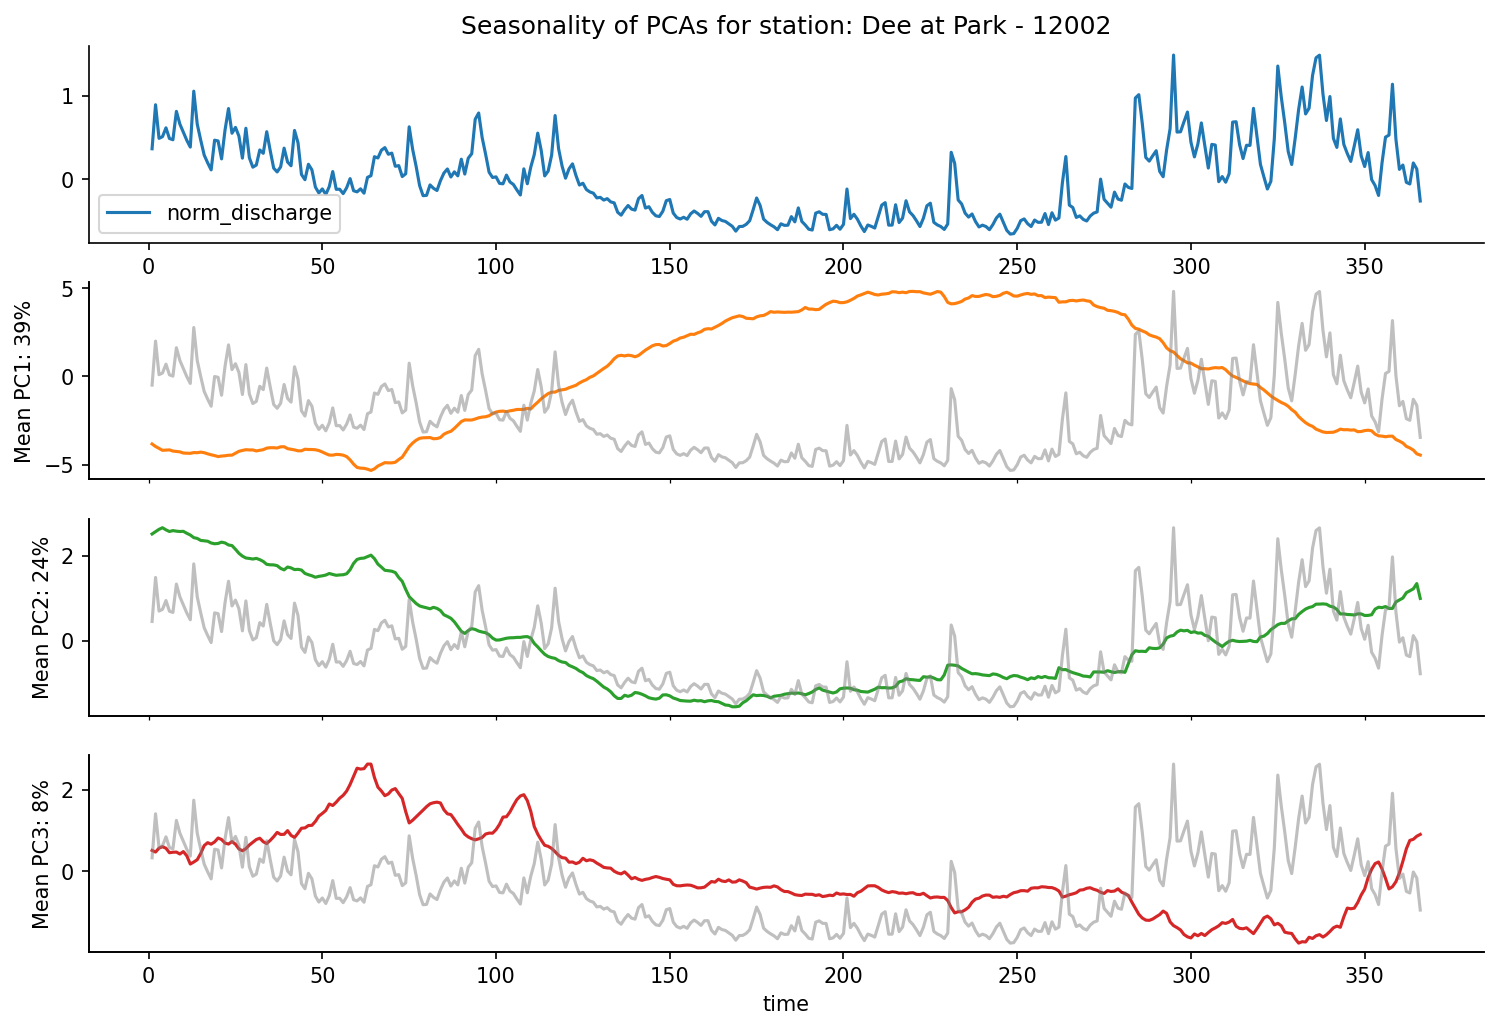

In [42]:
for station in all_pca.station_id.values:
    obs_q = get_normalised_df_from_dynamic("discharge_spec", station=station)
    fig, ax = plot_seasonality_of_pcs_vs_variable(
        all_pca.sel(station_id=[station]),
        obs_q,
        pca=pca_items[station],
        visualise_n_pcs=3,
        bground_obs_var=True,
    )
    sns.despine()
    break
    
    # fig.savefig(data_dir/f"RUNOFF/pca3_plots/{str(station)}.png")

# Compare to observed SM

In [44]:
def read_gb_sm_data() -> xr.Dataset:
    if not (data_dir / "RUNOFF/gb_sm_catchments_1993_2020.nc").exists():
        all_sm_ds = []
        for ix, path in enumerate(tqdm(list((data_dir / "RUNOFF/sm_data").glob("*Level*.csv")), desc="Reading SM Level")):
            # read in data
            df = (
                pd.read_table(d, sep=";", decimal=",")
                .drop("Unnamed: 0", axis=1)
                .rename({"Date": "time"}, axis=1)
                .astype({"time": "datetime64[ns]"})
            )
            # create index from station, time, rename column to soil level volume
            df = (
                df.melt(id_vars='time')
                .astype({"value": "float64", "variable": "int64"})
                .rename(
                    {
                        "value": f'swvl{path.name.split("Level_")[-1].replace(".csv", "")}',
                        "variable": "station_id"
                    }
                , axis=1)
                .set_index(["time", "station_id"])
            )    

            # convert to xarray
            ds = df.to_xarray()
            all_sm_ds.append(ds)

        ds = xr.combine_by_coords(all_sm_ds)
        ds.to_netcdf(data_dir / "RUNOFF/gb_sm_catchments_1993_2020.nc")


    else: 
        ds = xr.open_dataset(data_dir / "RUNOFF/gb_sm_catchments_1993_2020.nc")
    
    return ds
        
        
def old_read_obs_sm() -> xr.Dataset:
    # read in data
    obs_sm = pd.read_table(data_dir / "RUNOFF/Soil_Moisture_Catchments.csv", sep=";", decimal=",").drop("Unnamed: 0", axis=1)
    
    # convert to xarray
    sm_df = obs_sm.set_index("Date").stack().reset_index().rename({0: "soil_moisture", "level_1": "station_id", "Date": "time"}, axis=1)
    sm_df["time"] = pd.to_datetime(sm_df["time"])
    sm_df = sm_df.sort_values(["station_id", "time"]).set_index(["time", "station_id"])
    sm = sm_df.to_xarray()
    
    return sm

In [50]:
sm = read_gb_sm_data()
sm_df = sm.to_dataframe()

In [46]:
df = sm.groupby("time.dayofyear").std().mean(dim="station_id").to_dataframe()
df.head()

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,swvl1,swvl2,swvl3,swvl4
dayofyear,,,,
1,0.019311,0.018356,0.022050,0.018227
2,0.019916,0.019342,0.022032,0.018258
3,0.020665,0.019695,0.022042,0.018294
4,0.019884,0.019624,0.022015,0.018327
5,0.019856,0.019204,0.021869,0.018367


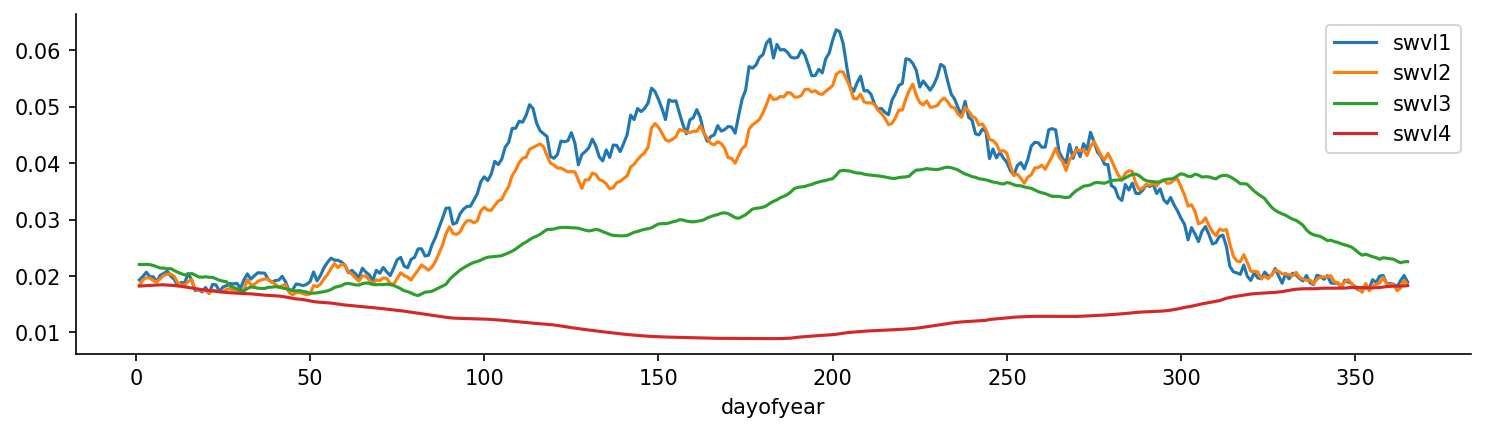

In [47]:
f, ax = plt.subplots(figsize=(12, 3))
df.iloc[:-1].plot(ax=ax)
sns.despine()

In [177]:
# NORMALIZE SM
def normalize_dataframe_by_basin(df: pd.DataFrame):
    assert all(np.isin(["time", "station_id"], df.reset_index().columns))
    scaler = StandardScaler()
    norm_ = df.groupby("station_id").apply(lambda x: scaler.fit_transform(x).flatten())

    norm_df = norm_.explode().reset_index().rename({0: "norm"}, axis=1).astype({"norm": "float64"})
    norm_df["time"] = df.reset_index().sort_values(["station_id", "time"])["time"]
    norm_df = norm_df.set_index(["station_id", "time"])
    
    return  norm_df


def normalize_xr_by_basin(ds):
    return (ds - ds.mean(dim="time")) / ds.std(dim="time")

In [179]:
norm_sm = normalize_xr_by_basin(sm)

In [90]:
norm_sm = normalize_xr_by_basin(sm)
norm_climatology = norm_sm.groupby("time.dayofyear").mean(dim="time")
norm_pca = all_pca.groupby("time.dayofyear").mean(dim="time")

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Plot multiple SWLs

In [140]:
def plot_obs_pca_clim(
    norm_climatology: xr.Dataset,
    norm_pca: xr.Dataset,
    station: str,
    pca: PCA,
    visualise_n_pcs: int = 3,
):
    # 1. calculate the climatology
    obs_clim = norm_climatology.sel(station_id=station).drop("station_id").to_dataframe()
    pca_clim = norm_pca.sel(station_id=station).drop("station_id").to_dataframe().reset_index("PC").pivot(columns="PC", values="value")
    pca_clim.columns = [f"PC_{c + 1}" for c in pca_clim.columns]

    # 2. create plot figure
    n_subplots = visualise_n_pcs + 1
    fig, axs = plt.subplots(n_subplots, 1, figsize=(12, 2*n_subplots))

    # 3. plot the observations (soil moisture)
    ax = axs[0]
    station_name = str(static["gauge_name"].to_dataframe().loc[int(station)].values)
    ax.set_title(f"Seasonality of PCAs for station: {station_name} - {station}")
    obs_clim.plot(ax=ax)

    # 4. plot each PC
    for ix in range(visualise_n_pcs):
        ax = axs[ix + 1]
        # plot the pca daat
        pc_data = pca_clim.loc[:, f"PC_{ix + 1}"]
        ax.plot(pc_data.index, pc_data.values)

        ratio = pca.explained_variance_ratio_[ix]
        ax.set_ylabel(f"Mean PC{ix + 1}: {ratio*100:.0f}%")
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_xlabel("")

        # plot bground observation data
        ax2 = ax.twinx()
        obs_clim.plot(ax=ax2, alpha=0.5, color='grey')
        ax2.get_legend().remove()
        ax2.set_yticklabels([])
        ax2.set_yticks([])
        None if ax2.get_legend() is None else ax2.get_legend().remove()

    return fig, ax

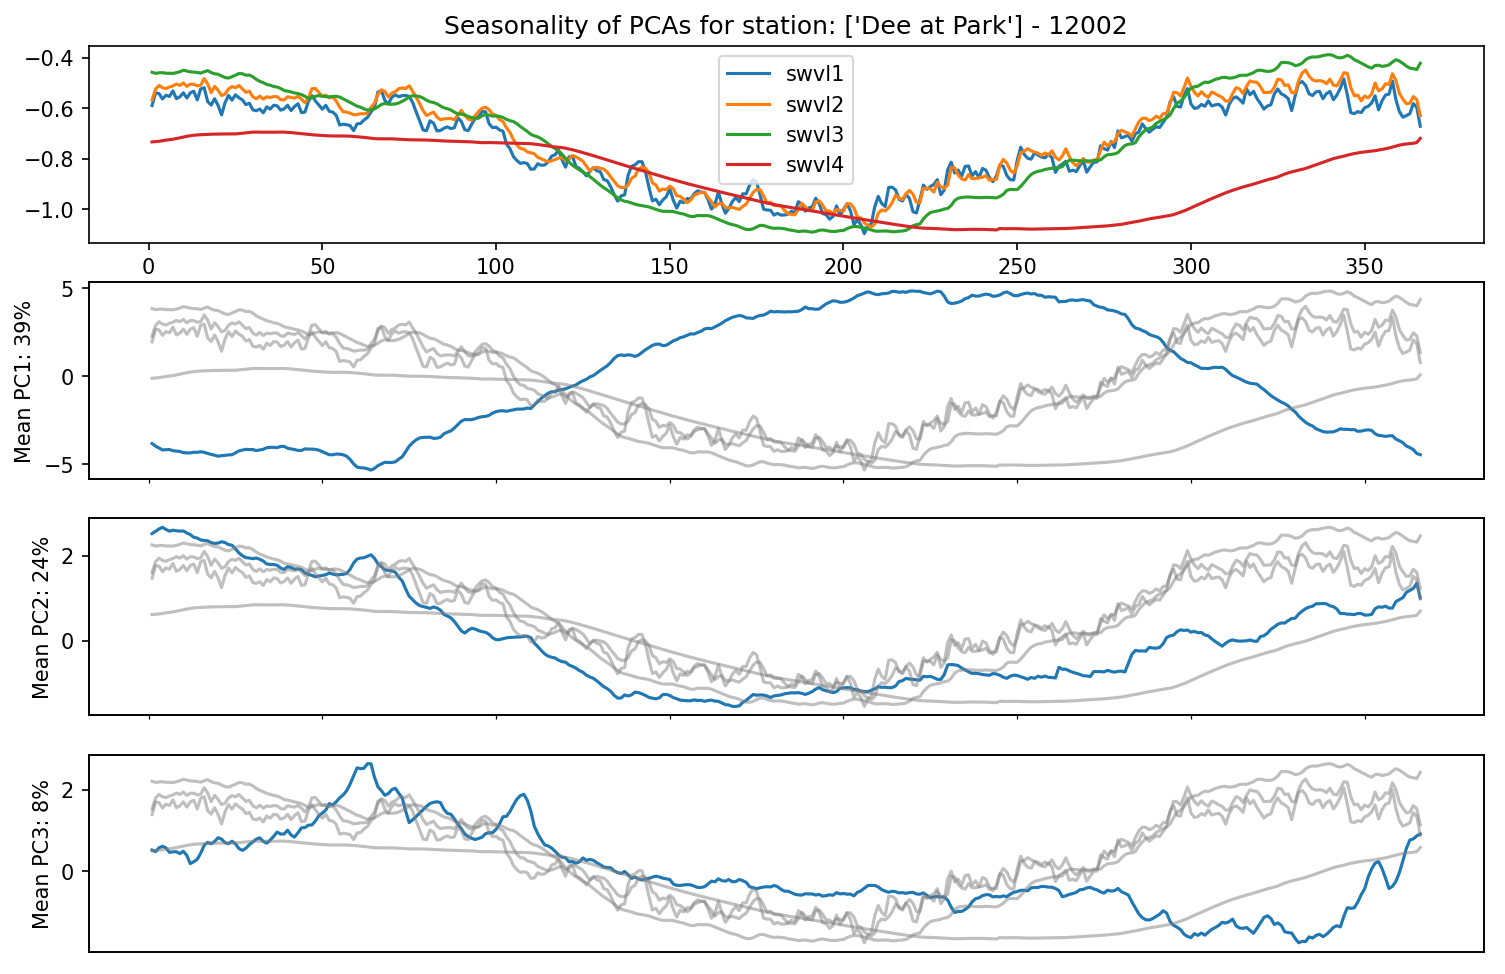

In [144]:
for ix, station in enumerate(all_pca.station_id.values):
    fig, ax = plot_obs_pca_clim(
        norm_climatology = norm_climatology,
        norm_pca = norm_pca,
        station = station,
        pca = pca_items[station],
        visualise_n_pcs=3,
    )
    break
    fig.savefig(data_dir / f"RUNOFF/sm_pca_plots/{station}.png")

In [45]:
station = "12002"
pca = pca_items[station]
eigenvectors = pca.components_
eigenvalues = pca.explained_variance_
weights = pca.explained_variance_ratio_
# print(eigenvalues)
# print(dir(pca))

In [46]:
# weights = 
# eigenvalues[:3] / eigenvalues.sum()

In [47]:
pc_d = all_pca.sel(station_id=station).groupby("time.dayofyear").mean().values
pc_d.shape

(366, 10)

In [48]:
weights

array([0.39067522, 0.2394751 , 0.08292336, 0.05216788, 0.03917949,
       0.03469807, 0.02507613, 0.01709282, 0.01463831, 0.01340844])

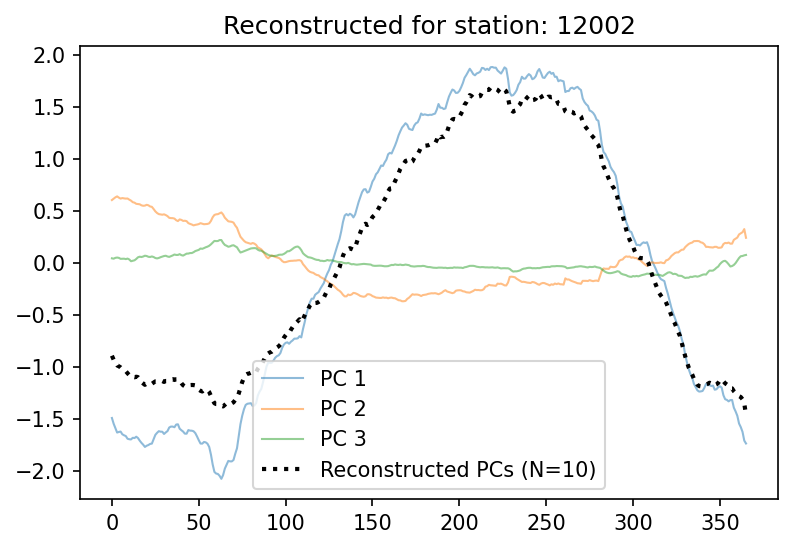

In [49]:
eigenvectors = pca.components_
eigenvalues = pca.explained_variance_
weights = pca.explained_variance_ratio_  # eigenvalues[:N_PCS] / eigenvalues.sum()

assert all(np.isclose((weights @ pc_d.T), np.dot(weights, pc_d.T)))

# obs_q.groupby("doy").mean().plot(label="Discharge", alpha=0.5, linewidth=1)
# sm_d.plot(label="Soil Moisture")
alphas = 0.5
fig, ax = plt.subplots()
ax.plot(pc_d[:, 0] * weights[0], label="PC 1", linewidth=1, alpha=alphas)
ax.plot(pc_d[:, 1] * weights[1], label="PC 2", linewidth=1, alpha=alphas)
ax.plot(pc_d[:, 2] * weights[2], label="PC 3", linewidth=1, alpha=alphas)
ax.plot((weights @ pc_d.T), label=f"Reconstructed PCs (N={N_PCS})", linewidth=2, color='k', ls=":")
ax.set_title(f"Reconstructed for station: {station}")
ax.legend();

# Linear Regression

In [155]:
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from typing import DefaultDict

### Create input/target data for the regression
- inputs =  normalised cell state data, take the mean for repeating days
- target data = normalised soil moisture

In [183]:
def normalize_xr_by_basin(ds):
    return (ds - ds.mean(dim="time")) / ds.std(dim="time")

norm_sm = normalize_xr_by_basin(sm)

In [156]:
# input_data = cs_data
input_data = norm_cs_data.groupby("time").mean()
input_data["station_id"] = [int(sid) for sid in input_data["station_id"]] 
input_data = input_data.to_dataset()

In [52]:
# target data = SOIL MOISTURE
target_data = norm_sm["swvl1"]
target_data["station_id"] = [int(sid) for sid in target_data["station_id"]] 

### build dataloaders

In [210]:
# # convert to pt lightning
# import os
# import torch
# from torch import nn
# import torch.nn.functional as F
# from torch.utils.data import DataLoader, random_split
# import pytorch_lightning as pl
# # k-fold cross validation = https://stackoverflow.com/a/59005890/9940782


# class Model2(pl.LightningModule):
#     def __init__(self, D_in: int = 64):
#         super().__init__()
#         self.model = torch.nn.Sequential(
#             torch.nn.Linear(D_in, 1)
#         ).cuda()
#         self.loss_fn = torch.nn.MSELoss(reduction="sum")
    
#     def forward(self, x):
#         # in lightning, forward defines the prediction/inference actions
#         pred = self.model(x)
#         return pred

#     def training_step(self, batch, batch_idx):
#         # training_step defined the train loop. It is independent of forward
#         (basin, time), (x, y) = batch
#         y_pred = self.model(x)
#         loss = self.loss_fn(y_pred, y)
#         # self.log('train_loss', loss)
#         return loss

# #     def validation_step(self, batch, batch_idx):
# #         # training_step defined the train loop. It is independent of forward
# #         (basin, time), (x, y) = batch
# #         y_pred = self.model(x)
# #         loss = self.loss_fn(y_pred, y)
# #         self.log('train_loss', loss)
# #         return loss


#     def configure_optimizers(self, learning_rate: float = 1e-2):
#         # optimizer
#         optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

#         return optimizer
    
    
# val_ratio = 0.1
# val_length = int(len(dataset) * val_ratio) 
# train_length = len(dataset) - val_length
# train, val = random_split(dataset, (train_length, val_length))
# train = dataset

# pl_model = Model2()
# trainer = pl.Trainer()
# trainer.fit(pl_model, DataLoader(train))

In [219]:
test_times = pd.date_range(config.test_start_date, config.test_end_date, freq="D")
bool_input_times = np.isin(input_data.time.values, test_times)
bool_target_times = np.isin(target_data.time.values, test_times)
test_times = list(
            set(target_data.time.values[bool_target_times]).intersection(
                set(input_data.time.values[bool_input_times])
            )
        )
test_times = np.array(sorted(test_times))

2007-11-25T00:00:00.000000000
2007-11-26T00:00:00.000000000


In [248]:
from typing import Any
import torch
from numpy import AxisError
# TODO: test/train mode


class CellStateDataset(Dataset):
    def __init__(
        self, input_data: xr.Dataset, target_data: xr.DataArray, config, mean: bool = True,
        mode: str = "train", set_device: bool = True
    ):
        assert all(np.isin(["time", "dimension", "station_id"], input_data.dims))
        assert "cell_state" in input_data
        assert all(np.isin(input_data.station_id.values, target_data.station_id.values))
        
        self.input_data = input_data
        self.set_device = set_device

        # All times that we have data for
        test_times = pd.date_range(config.test_start_date, config.test_end_date, freq="D")
        bool_input_times = np.isin(input_data.time.values, test_times)
        bool_target_times = np.isin(target_data.time.values, test_times)
        self.all_times = list(
            set(target_data.time.values[bool_target_times]).intersection(
                set(input_data.time.values[bool_input_times])
            )
        )
        
        # get train test split
        val_ratio = 0.1
        val_length = int(len(test_times) * val_ratio) 
        train_length = len(test_times) - val_length
        self.train_times = self.all_times[:train_length][-1]
        self.val_times = self.all_times[-val_length:][0]
        
        if mode == "train":
            # get input/target data
            self.input_data = self.input_data.sel(time=self.train_times)
            self.target_data = target_data.sel(time=self.train_times)

        elif mode == "test":
            # get input/target data
            self.input_data = self.input_data.sel(time=self.val_times)
            self.target_data = target_data.sel(time=self.val_times)
        
        elif mode == "all":
            # get input/target data
            self.input_data = self.input_data.sel(time=self.all_times)
            self.target_data = target_data.sel(time=self.all_times)

        else:
            raise NotImplementedError 

        # basins
        self.basins = input_data.station_id.values
        
        # dimensions
        self.dimensions = len(input_data.dimension.values)
        
        # create x y pairs
        self.create_samples()
            
    def __len__(self):
        return len(self.samples)
    
    def create_samples(self):
        self.samples = []
        self.basin_samples = []
        self.time_samples = []
        
        for basin in self.basins:
            # read the basin data
            X = self.input_data["cell_state"].sel(station_id=basin).values.astype("float64")
            Y = self.target_data.sel(station_id=basin).values.astype("float64")
            
            finite_indices = np.logical_and(np.isfinite(Y), np.isfinite(X).all(axis=1))
            # finite_indices = np.logical_and(np.isfinite(Y), np.isfinite(X).all())
            X, Y = X[finite_indices], Y[finite_indices]
            times = self.input_data["time"].values[finite_indices].astype(float)

            # convert to Tensors
            X = torch.from_numpy(X).float()
            Y = torch.from_numpy(Y).float()
            if self.set_device:
                X = X.to("cuda:0")
                Y = Y.to("cuda:0")
            
            
            # create unique samples [(64,), (1,)]
            samples = [(x, y.reshape(-1)) for (x, y) in zip(X, Y)]
            self.samples.extend(samples)
            self.basin_samples.extend([basin for _ in range(len(samples))])
            self.time_samples.extend(times)
        

    def __getitem__(self, item: int) -> Tuple[Tuple[str, Any], Tuple[torch.Tensor]]:
        basin = str(self.basin_samples[item])
        time = self.time_samples[item]
        x, y = self.samples[item]
        
        return (basin, time), (x, y)
    

def create_model(dataset):
    D_in = dataset.dimensions
    model = torch.nn.Sequential(torch.nn.Linear(D_in, 1))
    model = model.to("cuda:0")
    return model


def train_model(model, loader, learning_rate: float = 1e-2, n_epochs: int = 5):
    loss_fn = torch.nn.MSELoss(reduction="sum")

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    #  TRAIN
    losses = []
    for epoch in range(n_epochs):
        for (basin, time), data in loader:
            X, y = data
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            # train/update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.detach().cpu().numpy())
            
    return model, losses
            

def to_xarray(predictions) -> xr.Dataset:
    return pd.DataFrame(predictions).set_index(["time", "station_id"]).to_xarray()
    

def calculate_predictions(model, loader):
    from collections import defaultdict

    predictions = defaultdict(list)

    with torch.no_grad():
        for (basin, time), data in loader:
            X, y = data
            y_hat = model(X)
            predictions["time"].extend(pd.to_datetime(time))
            predictions["station_id"].extend(basin)
            predictions["y_hat"].extend(y_hat.detach().cpu().numpy().flatten())
            predictions["y"].extend(y.detach().cpu().numpy().flatten())
            
    return to_xarray(predictions)

    
    
    
dataset = CellStateDataset(
    input_data=input_data, 
    target_data=target_data, 
    config=config,
    mode="all"
)
# loader = DataLoader(dataset, batch_size=256, shuffle=True)
            
# model = create_model(dataset)
# model, losses = train_model(model, loader, n_epochs=10, learning_rate=0.1)

# plt.plot(losses)
# preds.drop("doy").to_dataframe().to_csv(data_dir / "RUNOFF/pca_linear_regression.csv")

In [267]:
# # input_data = cs_data
# input_data = norm_cs_data.groupby("time").mean()
# input_data["station_id"] = [int(sid) for sid in input_data["station_id"]] 
# input_data = input_data.to_dataset()

# # target data = SOIL MOISTURE
# target_data = norm_sm["swvl1"]
# target_data["station_id"] = [int(sid) for sid in target_data["station_id"]] 

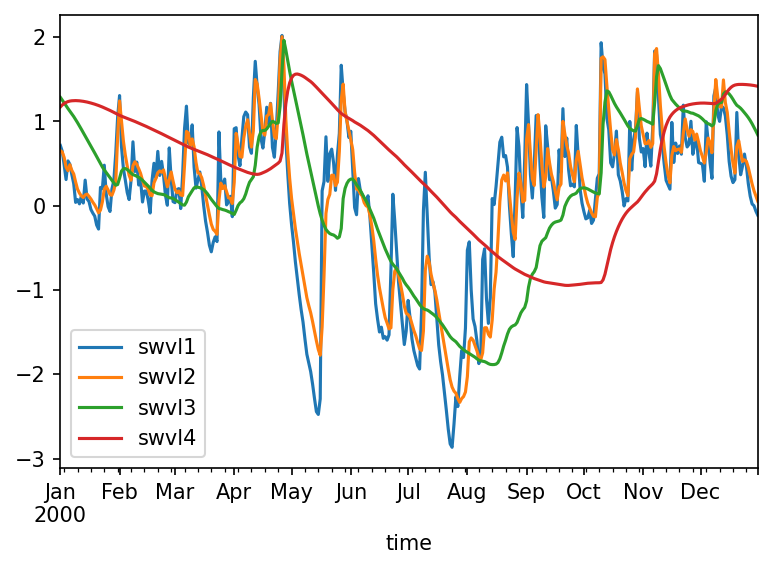

In [273]:
norm_sm.isel(station_id=10).sel(time=slice("2000", "2000")).to_dataframe().plot()

swvl1
swvl2
swvl3
swvl4


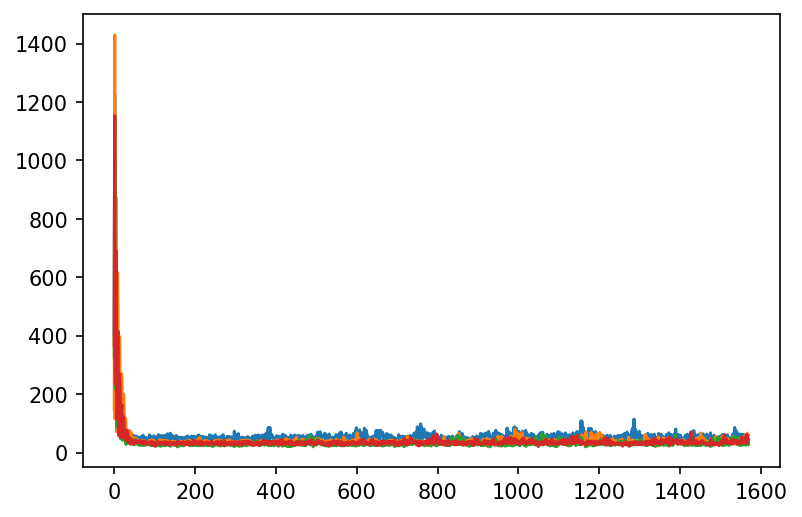

In [269]:
# models = []
loaders = []
losses_list = []
all_preds = []

for soil_level in list(norm_sm.data_vars):
    print(soil_level)
    # target data = SOIL MOISTURE
    target_data = norm_sm[soil_level]
    target_data["station_id"] = [int(sid) for sid in target_data["station_id"]] 
    dataset = CellStateDataset(
        input_data=input_data, 
        target_data=target_data, 
        config=config,
        mode="all"
    )
    loader = DataLoader(dataset, batch_size=256, shuffle=True)
            
    model = create_model(dataset)
    model, losses = train_model(model, loader, n_epochs=10, learning_rate=0.1)
    plt.plot(losses)
    
    #
    losses_list.append(losses)
    models.append(model)
    loaders.append(loader)

    preds = calculate_predictions(model, loader)
    
    all_preds.append(preds)

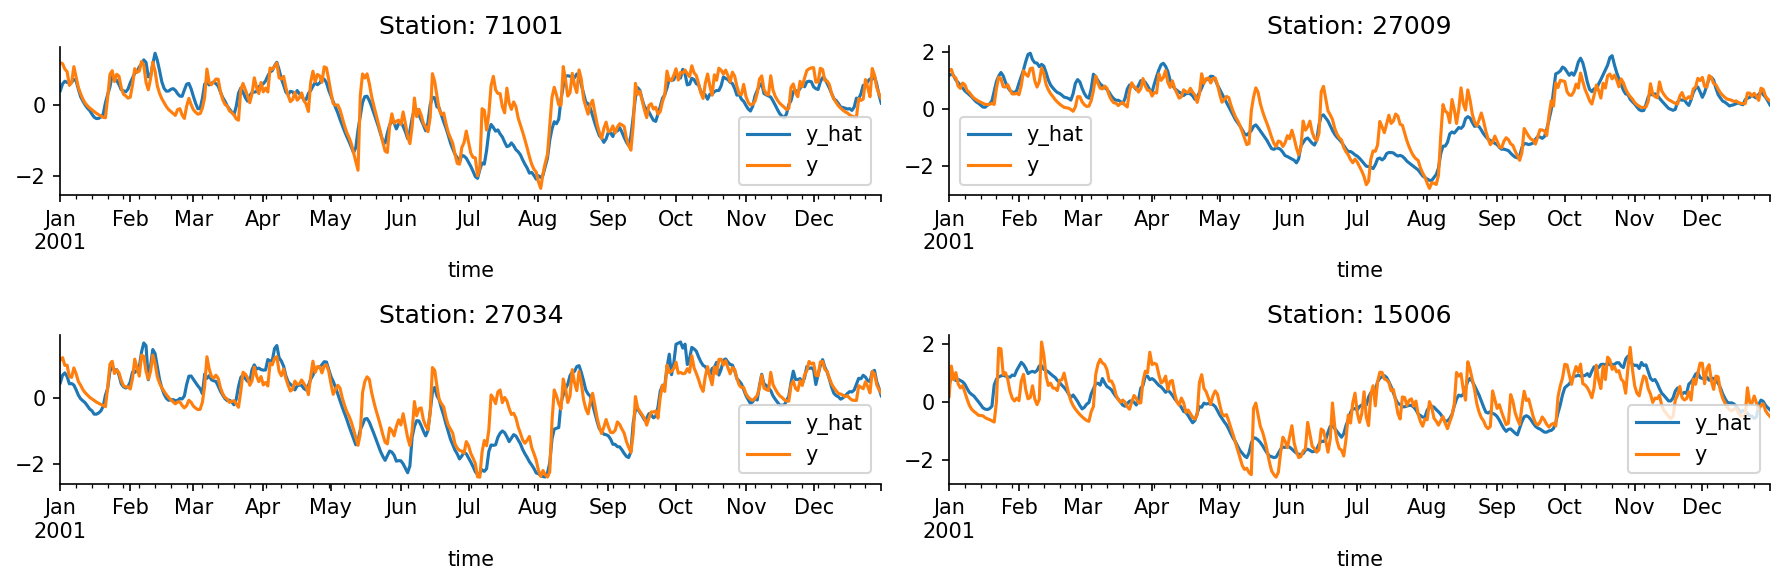

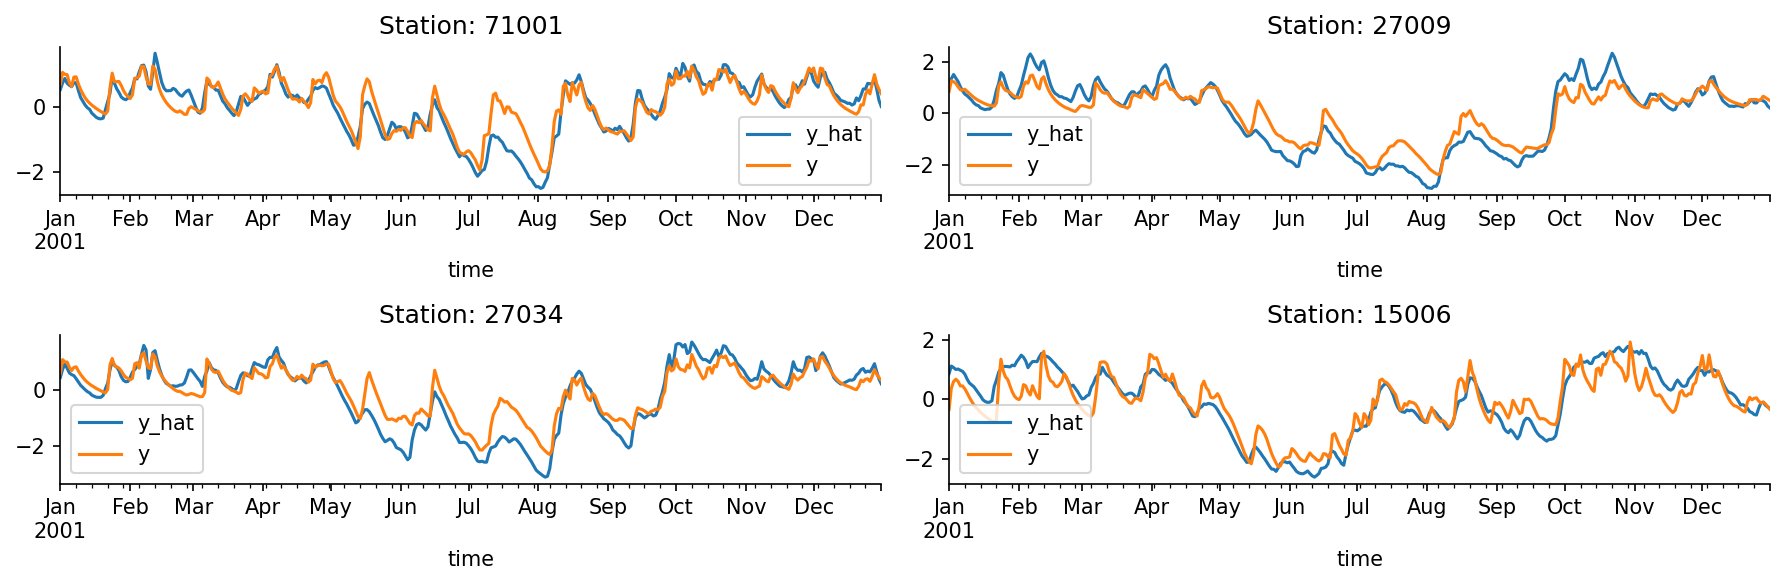

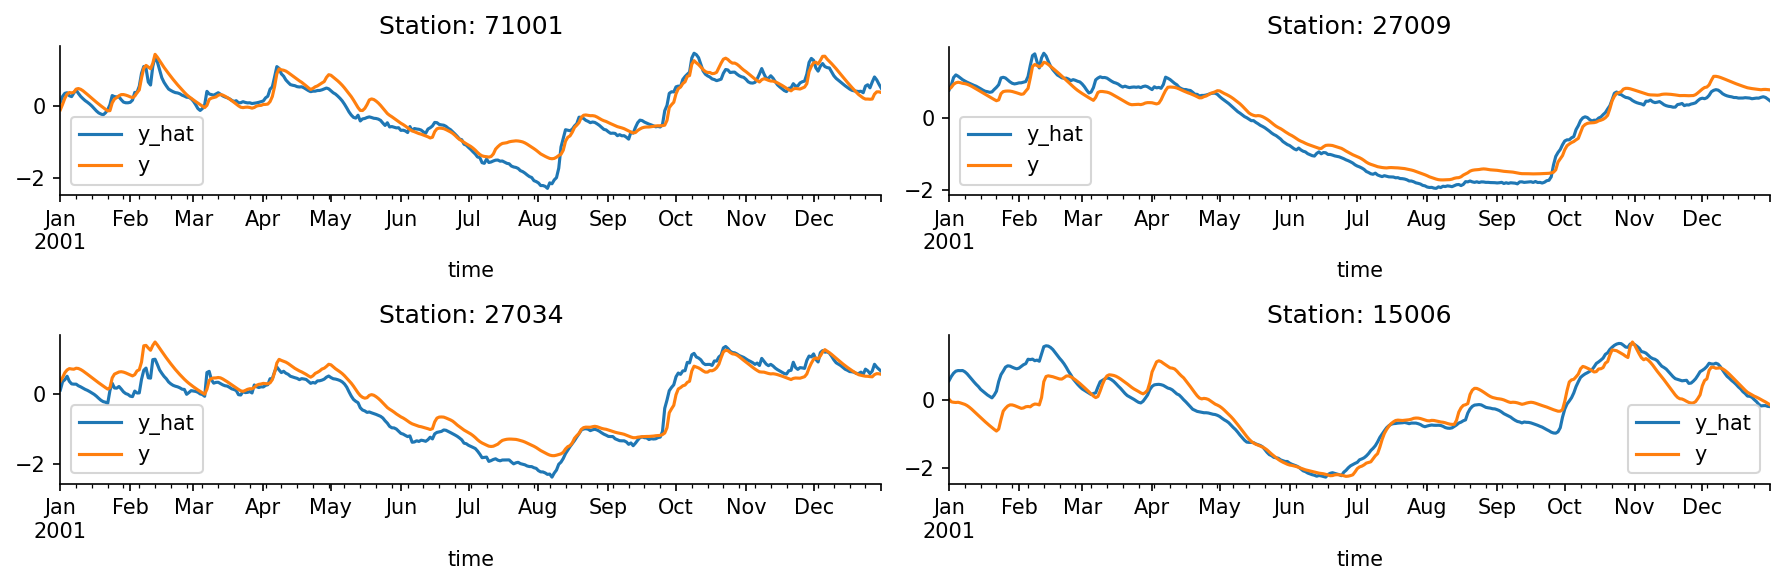

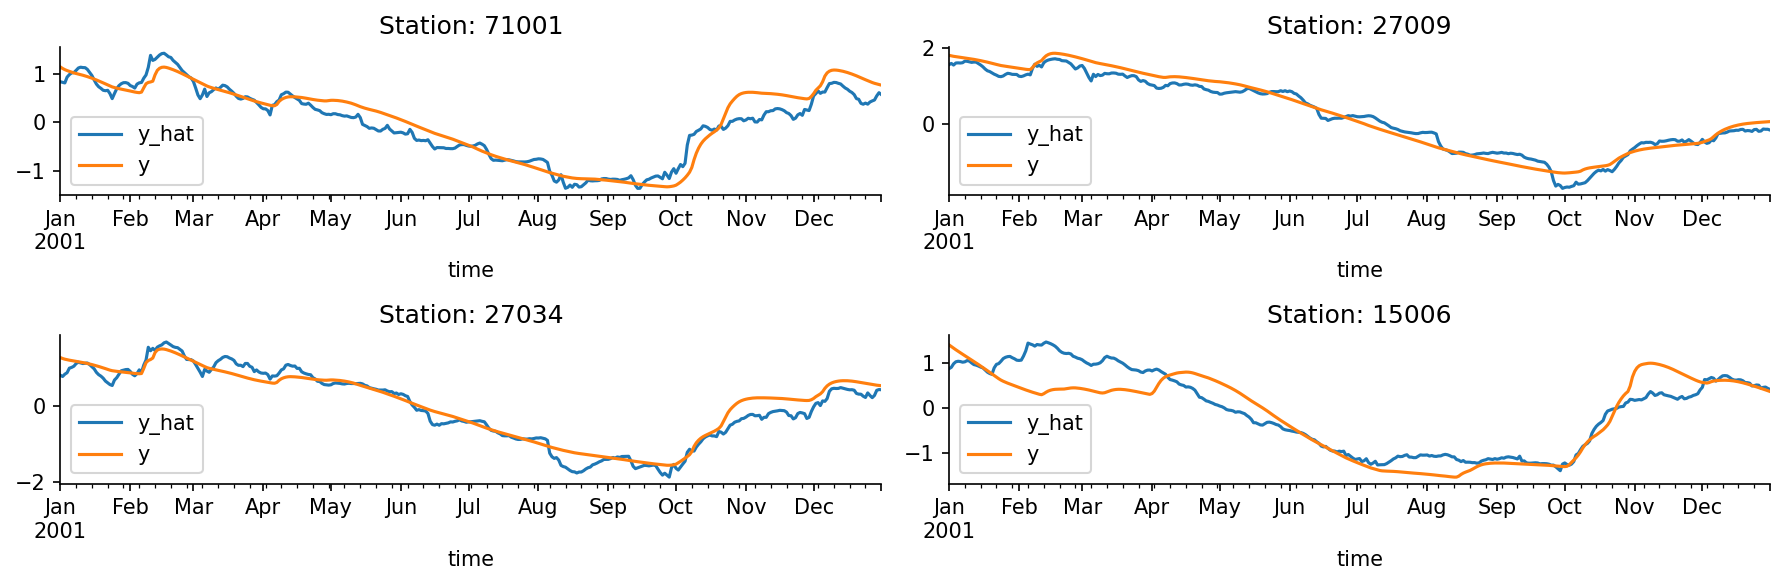

In [279]:
# DISCHARGE
# station = 10003; year = 2004
# station = 10003; year = 1998
# SOIL MOISTURE
# station = 10003; year = 2005
# # station = 10002; year = 2004

stations = np.random.choice([sid for sid in preds.station_id.values if str(sid) != "27041"], 4, replace=False)
year = np.random.choice(np.unique(preds["time.year"]))

for layer_ix in range(len(all_preds)):
    f, axs = plt.subplots(2, 2, figsize=(6*2, 2*2))
    preds = all_preds[layer_ix]
    for ix, station in enumerate(stations):
        ax = axs[np.unravel_index(ix, (2, 2))]

        preds.sel(station_id=station, time=slice(f"{year}", f"{year}")).to_dataframe().plot(ax=ax)
        ax.set_title(f"Station: {station}")
        if ix == 0:
            ax.legend()

    sns.despine()
    plt.tight_layout()

In [255]:
preds["doy"] = preds["time.dayofyear"]
climatology = preds.groupby("doy").mean()
climatology_std = preds.groupby("doy").std()

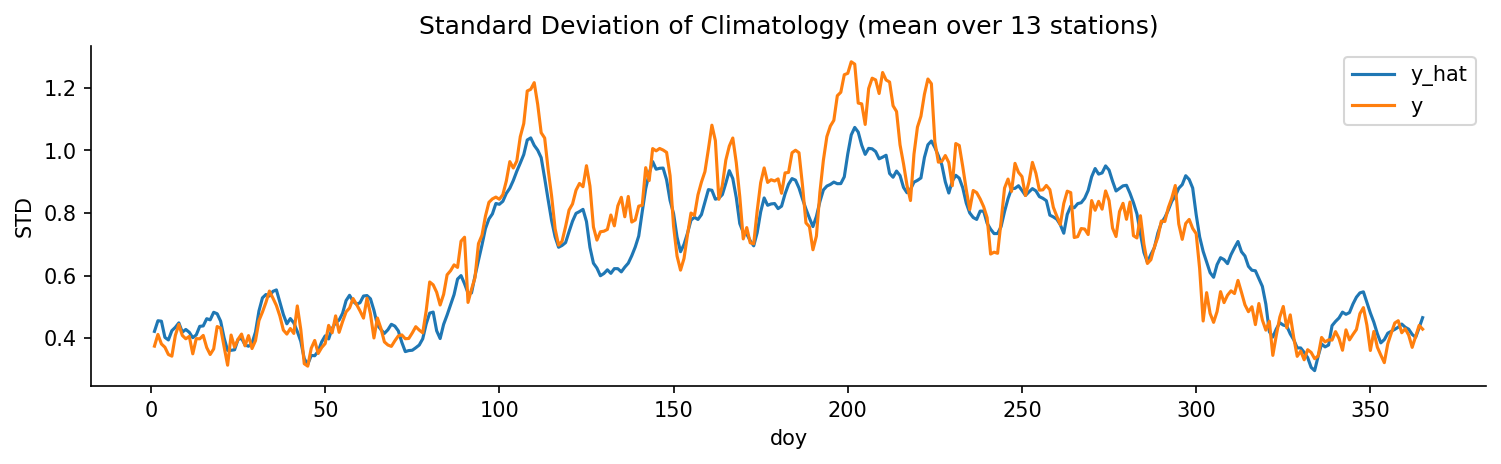

In [256]:
f, ax = plt.subplots(figsize=(12, 3))
climatology_std.mean("station_id").to_dataframe()[:-1].plot(ax=ax)
ax = plt.gca()
ax.set_ylabel("STD")
ax.set_title("Standard Deviation of Climatology (mean over 13 stations)")
sns.despine()

In [257]:
def create_mean_upper_lower_df(climatology: xr.Dataset, climatology_std: xr.Dataset, station: int, n_stds: int = 1) :
    # NOTE: dropping the final index (leap day)
    d_std = climatology_std.sel(station_id=station).to_dataframe().iloc[:-1].drop("station_id",axis=1)
    d = climatology.sel(station_id=station).to_dataframe().iloc[:-1].drop("station_id",axis=1)
    return pd.concat([
        d,
        (d + (n_stds * d_std)).rename(dict(zip(d.columns, [f"{c}_upper" for c in d.columns])), axis=1),
        (d - (n_stds * d_std)).rename(dict(zip(d.columns, [f"{c}_lower" for c in d.columns])), axis=1),
    ], axis=1)


# create_mean_upper_lower_df(climatology, climatology_std, station)

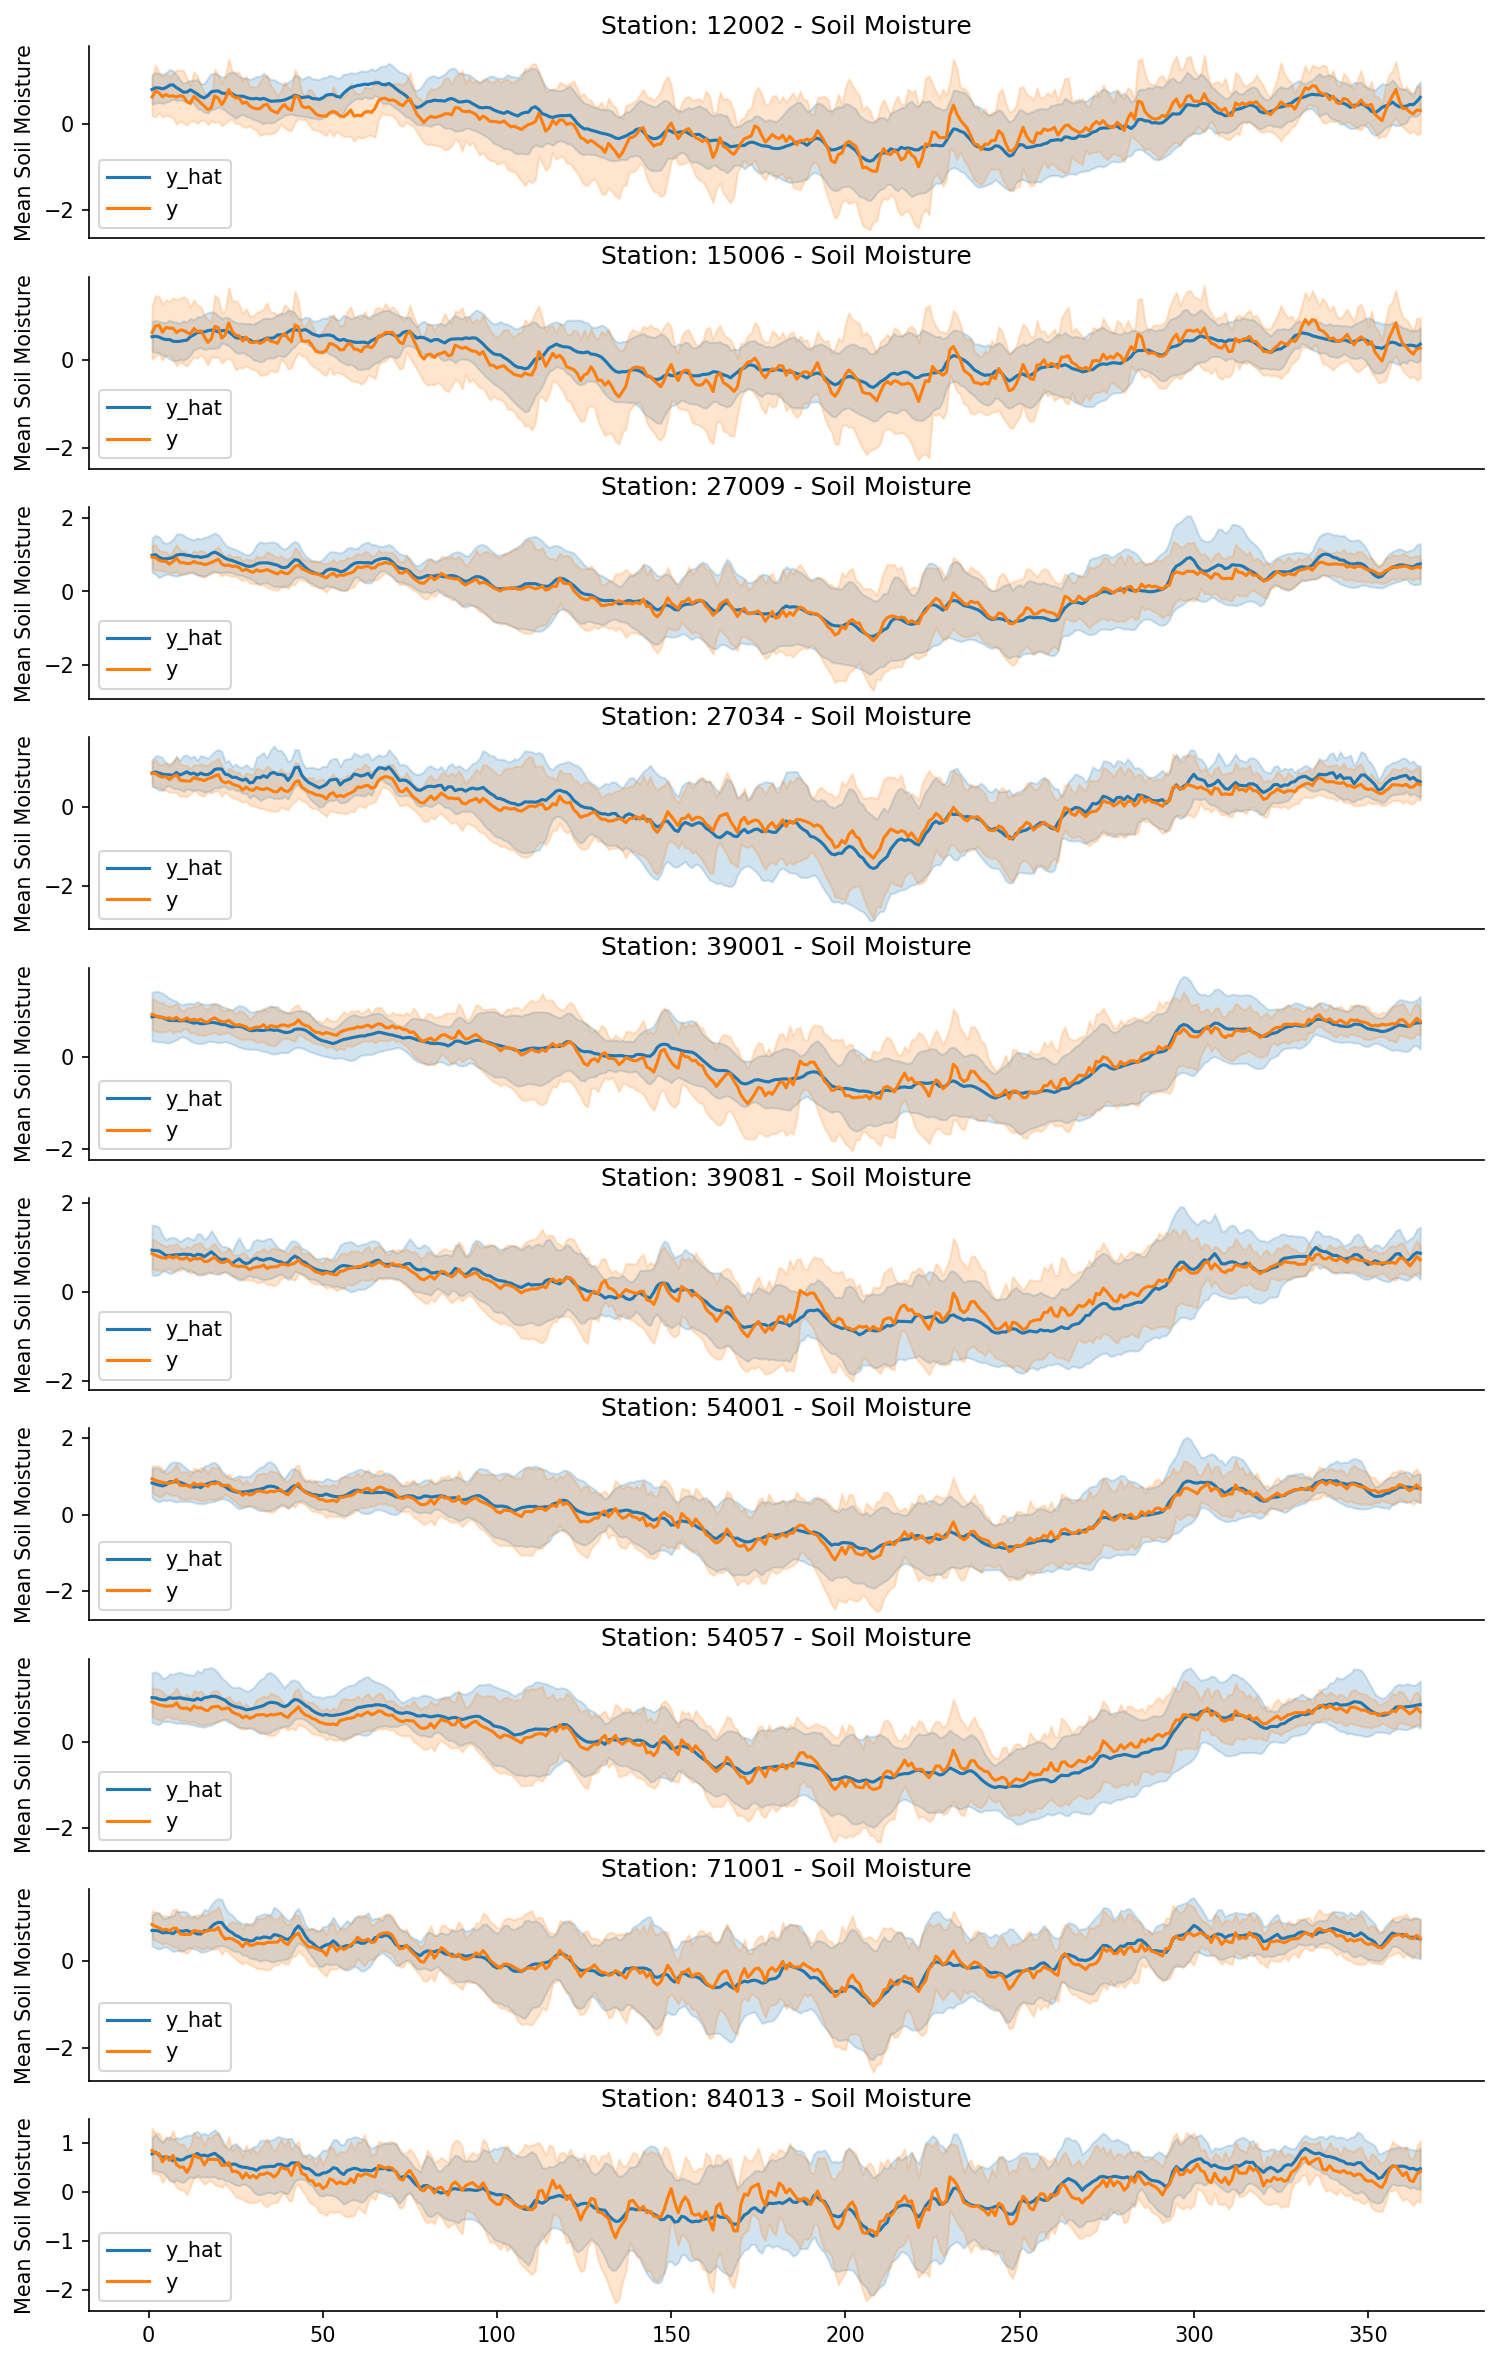

In [258]:
plot_stds = True

fig, axs = plt.subplots(len(climatology.station_id.values),1, figsize=(12, 2*len(climatology.station_id.values)))

for ix, station in enumerate(climatology.station_id.values):
    ax = axs[ix]
    # (the final is the leap day ...)
    d = create_mean_upper_lower_df(climatology, climatology_std, station=station, n_stds=1)
    # d.plot(ax=ax)
    ax.plot(d.index, d["y_hat"], color=sns.color_palette()[0], label="y_hat")
    ax.plot(d.index, d["y"], color=sns.color_palette()[1], label="y")
    if plot_stds:
        ax.fill_between(
            d.index,
            d["y_hat_upper"], d["y_hat_lower"],
            alpha=0.2, color=sns.color_palette()[0]
        )
        ax.fill_between(
            d.index,
            d["y_upper"], d["y_lower"],
            alpha=0.2, color=sns.color_palette()[1]
        )
    
    ax.legend()
    ax.set_title(f"Station: {station} - Soil Moisture")
    ax.set_ylabel("Mean Soil Moisture")
    sns.despine()
    if ix != len(climatology.station_id.values) - 1:
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_xlabel("")

# Diagnose Errors

In [121]:
sm_raw = xr.open_dataset(data_dir / "gb_soil_moisture.nc")
# df = sm_raw.groupby("time.dayofyear").std().mean(dim=["lat", "lon"]).to_dataframe()
# display(df.head())

In [124]:
raw_mean_clim = sm_raw.groupby("time.dayofyear").mean().mean(dim=["lat", "lon"])
raw_std_clim = sm_raw.groupby("time.dayofyear").std().mean(dim=["lat", "lon"])

n_stds = 1
d = raw_mean_clim.to_dataframe().iloc[:-1]
d_std = raw_std_clim.to_dataframe().iloc[:-1]
ul_df = pd.concat([
    d,
    (d + (n_stds * d_std)).rename(dict(zip(d.columns, [f"{c}_upper" for c in d.columns])), axis=1),
    (d - (n_stds * d_std)).rename(dict(zip(d.columns, [f"{c}_lower" for c in d.columns])), axis=1),
], axis=1)

/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [128]:
ul_df

,swvl1,swvl1_upper,swvl1_lower
dayofyear,,,
1,0.411995,0.432097,0.391892
2,0.409472,0.429036,0.389907
3,0.409686,0.430188,0.389183
4,0.407185,0.427164,0.387206
5,0.406956,0.426673,0.387239
...,...,...,...
361,0.173895,0.214728,0.133062
362,0.173186,0.213860,0.132513
363,0.173599,0.214393,0.132804


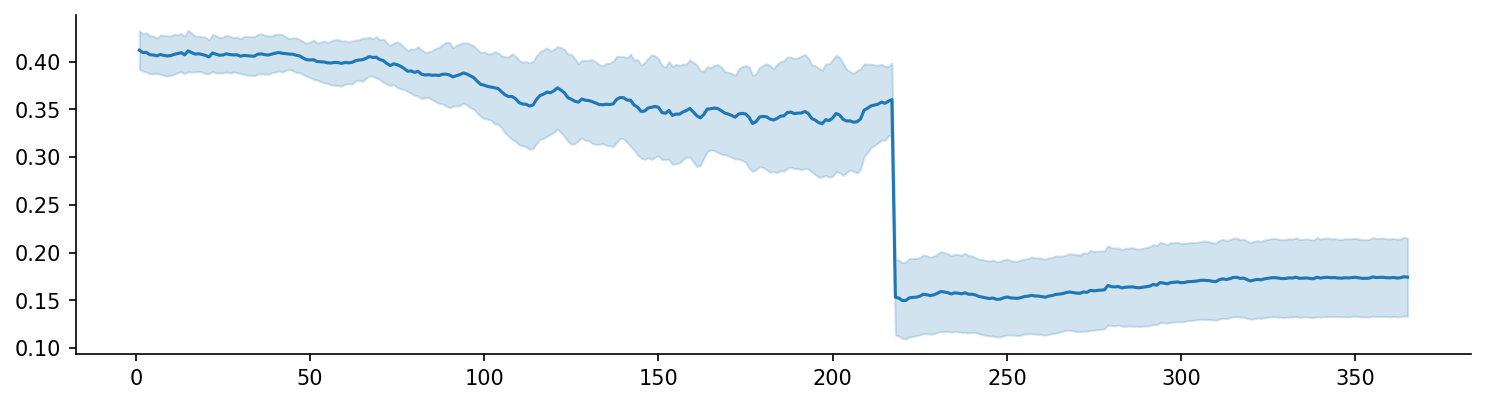

In [130]:
var = "swvl1"
f, ax = plt.subplots(figsize=(12, 3))

ax.plot(ul_df.index, ul_df[var], color=sns.color_palette()[0], label="y")
if True:
    ax.fill_between(
        ul_df.index,
        ul_df[f"{var}_upper"], ul_df[f"{var}_lower"],
        alpha=0.2, color=sns.color_palette()[0]
    )
sns.despine()